In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
import os
fileList = os.listdir("data/kaggle/")

In [5]:
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName != "all":
        companyList.append(companyName)
print(companyList)

['JPM', 'MSFT', 'JNJ', 'UNH', 'CAT', 'AABA', 'HD', 'CVX', 'MMM', 'AMZN', 'CSCO', 'XOM', 'VZ', 'WMT', 'GS', 'AAPL', 'AXP', 'GOOGL', 'UTX', 'KO', 'MRK', 'TRV', 'IBM', 'INTC', 'PFE', 'GE', 'DIS', 'PG', 'BA', 'MCD', 'NKE']


In [7]:
# First, we get the data
stockList = ["GE", "MSFT", "GOOGL", "AAPL", "AMZN", "IBM", "CSCO"]
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("data/kaggle/" + i + "_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])

In [8]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2015", "Close")

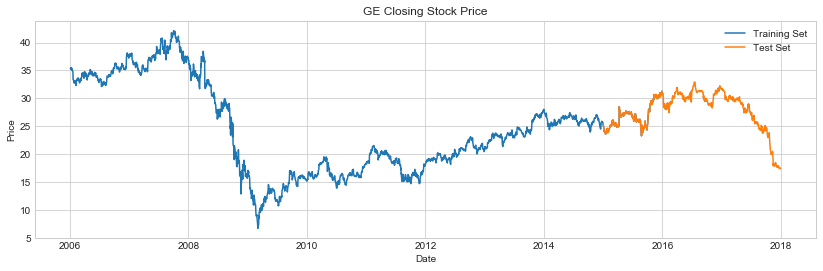

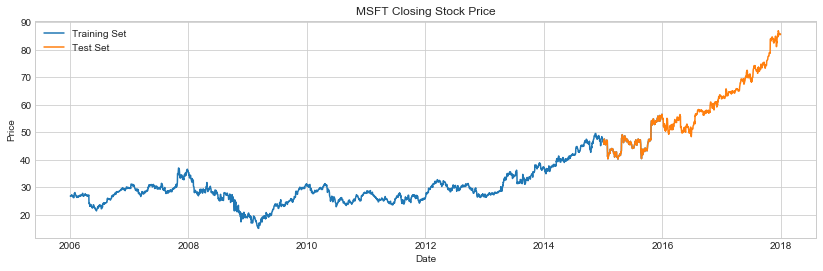

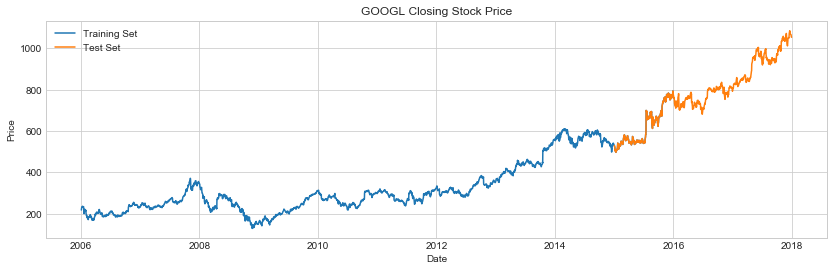

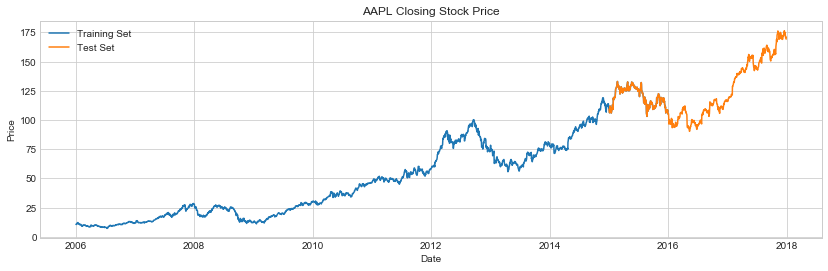

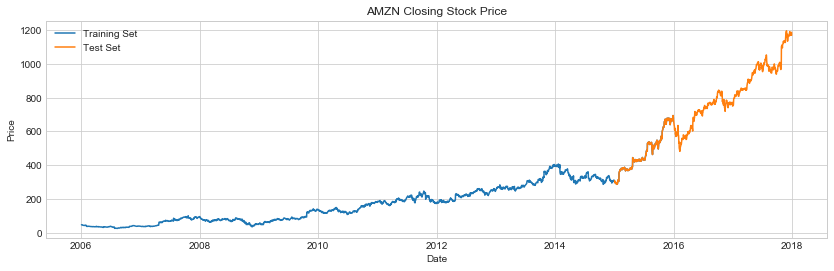

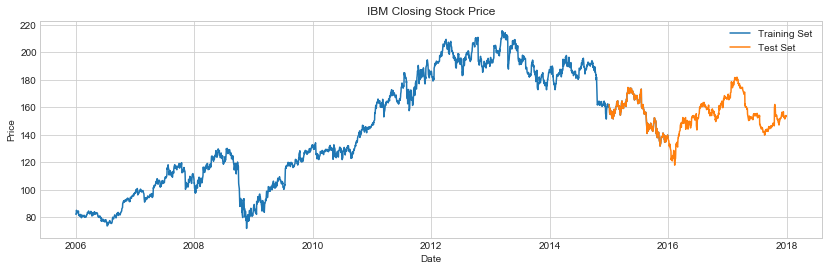

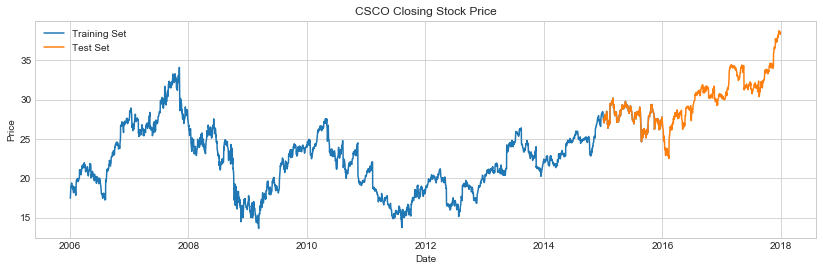

In [9]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [10]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [11]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

GE (2517, 1)
MSFT (2516, 1)
GOOGL (2516, 1)
AAPL (2516, 1)
AMZN (2516, 1)
IBM (2517, 1)
CSCO (2516, 1)


GE (755, 1)
MSFT (755, 1)
GOOGL (755, 1)
AAPL (755, 1)
AMZN (755, 1)
IBM (755, 1)
CSCO (755, 1)


In [12]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2516):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 755):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [13]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
GE,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
MSFT,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
GOOGL,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
AAPL,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
AMZN,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
IBM,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
CSCO,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"


In [14]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to GE

Epoch 1/10
2456/2456 [==============================] - 15s 6ms/step - loss: 0.0769
Epoch 2/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0277
Epoch 3/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0209
Epoch 4/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0217
Epoch 5/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0188
Epoch 6/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0150
Epoch 7/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0165
Epoch 8/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0162
Epoch 9/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0137
Epoch 10/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0138
Fitting to MSFT
Epoch 1/10
2456/2456 [==============================] - 12s 5ms/step - loss: 0.0086
Epoch 2/10
2456/2456 [======================

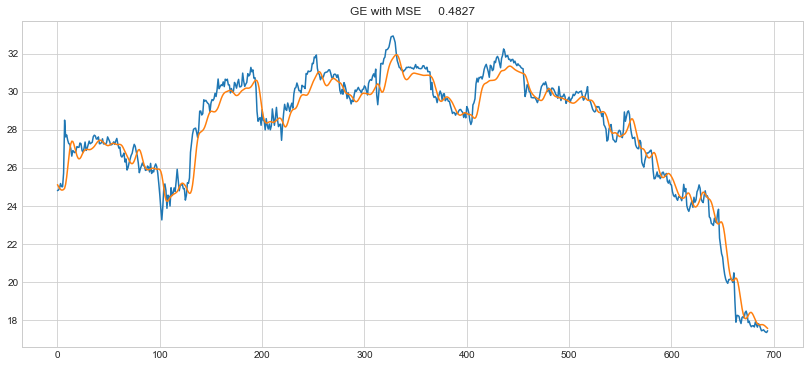

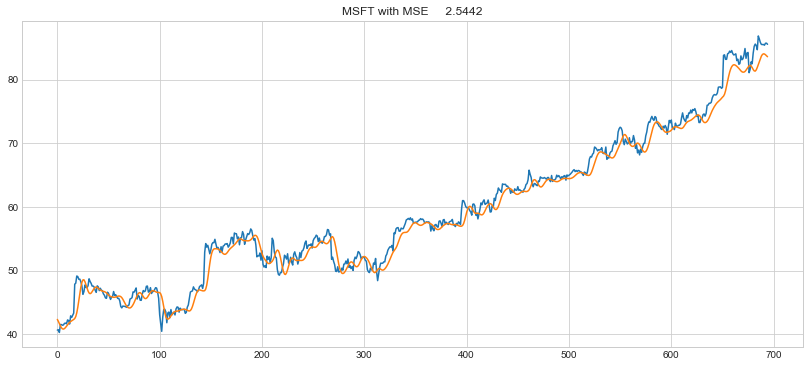

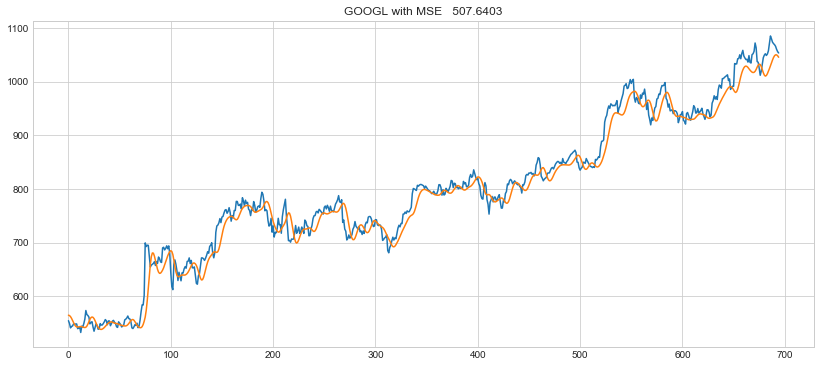

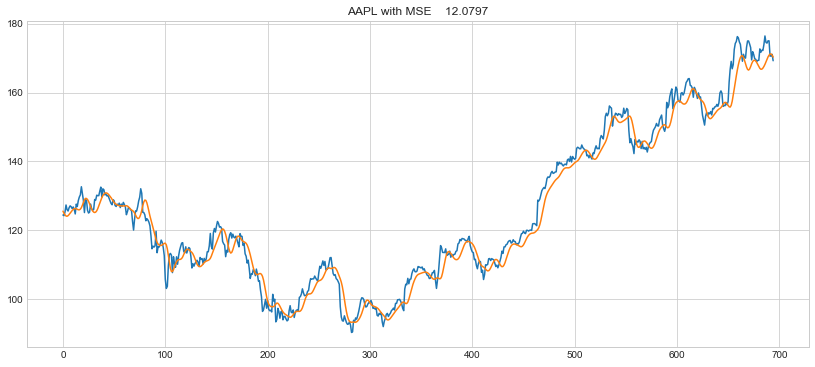

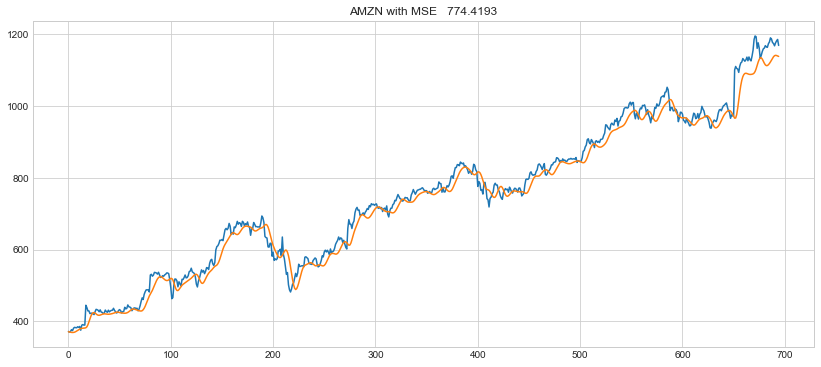

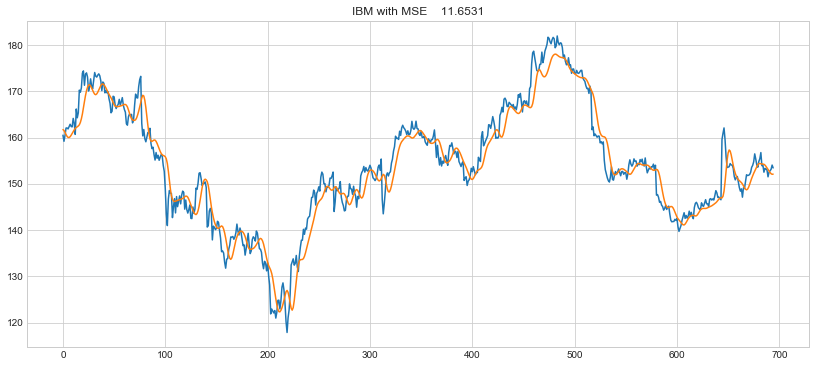

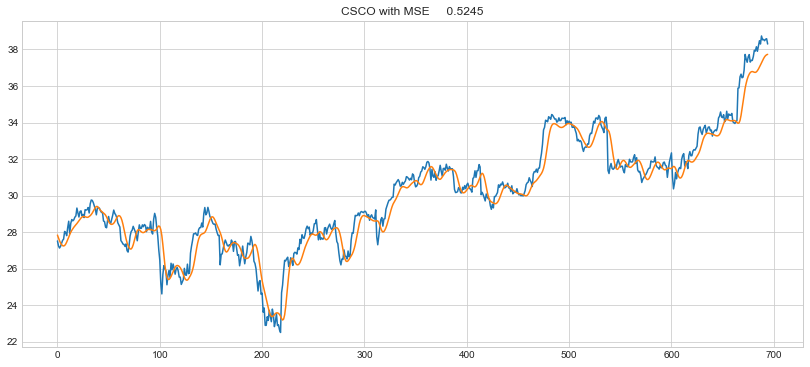

In [15]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [18]:
time_index = df_new["CSCO"]["Test"][60:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.plot(df_true)
    plt.plot(df_pred_lag)

MSE without Lag 11.653070674286045
MSE with Lag 5 2.625066188166229


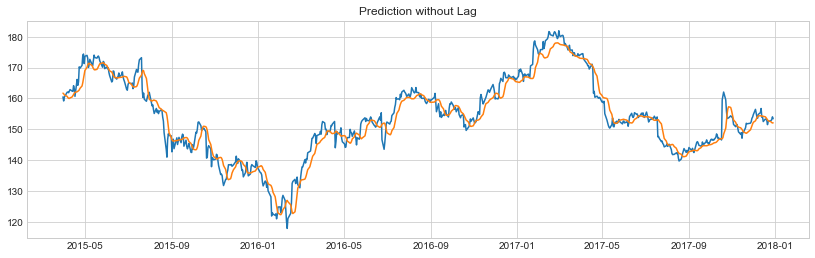

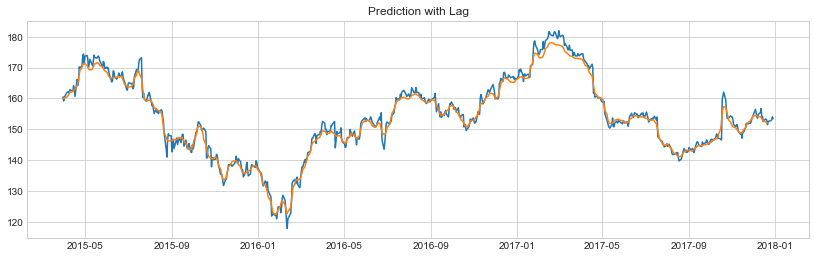

In [19]:
lagging(pred_result["IBM"], -5, time_index)